In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [2]:
occ_by_ind = pd.read_excel("../data/OES/natsector_M2021_dl.xlsx")

In [3]:
# A lot of total employment and wage estimates for "major" are showing up as unavailable. At some point we need 
# to estimate them from more granular occupation data
occ_by_ind = occ_by_ind[occ_by_ind['O_GROUP'] == 'major'][['NAICS', 'NAICS_TITLE', "OCC_CODE", "OCC_TITLE", "TOT_EMP"]]
occ_by_ind.loc[:, 'TOT_EMP'] = pd.to_numeric(occ_by_ind['TOT_EMP'], errors='coerce').fillna(0)
occ_by_ind.loc[:, 'EMP_PCT'] = occ_by_ind['TOT_EMP']/occ_by_ind.groupby('OCC_CODE')['TOT_EMP'].transform(sum)
pivot_df = occ_by_ind.pivot_table(columns=['OCC_TITLE'], index=['NAICS_TITLE'], values='EMP_PCT').fillna(0)

In [4]:
index_dict = {'Food S':'Accommodation and Food Services', 'Rec':'Arts, Entertainment, and Recreation', 
                'Const':'Construction', 'Educ S':'Educational Services', 'Fin':'Finance and Insurance', 
                'Gov':'Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)', 
                'Health':'Health Care and Social Assistance',
                'Info': 'Information', 'Mining':'Mining, Quarrying, and Oil and Gas Extraction', 
                'Manu': 'Manufacturing', 'Other S':'Other Services (except Public Administration)', 
                'Bus S': 'Professional, Scientific, and Technical Services', 
                'Real Est':'Real Estate and Rental and Leasing', 'Retail':'Retail Trade', 'Trans':'Transportation and Warehousing',
                'Whsale':'Wholesale Trade', 'Management':'Management of Companies and Enterprises',
                'Admin': 'Administrative and Support and Waste Management and Remediation Services', 
                'Agri': 'Agriculture, Forestry, Fishing and Hunting'}
occ_map = {'Architecture and Engineering Occupations': 'Archi + Eng', 
           'Arts, Design, Entertainment, Sports, and Media Occupations': 'Arts',
           'Building and Grounds Cleaning and Maintenance Occupations': 'Building Maintenance',
           'Business and Financial Operations Occupations': 'Business Ops',
           'Community and Social Service Occupations': 'Social Service',
           'Computer and Mathematical Occupations': 'Comp + Math',
           'Construction and Extraction Occupations': 'Construction',
           'Educational Instruction and Library Occupations': 'Education',
           'Farming, Fishing, and Forestry Occupations': 'Farm + Fish + Forestry',
           'Food Preparation and Serving Related Occupations': 'Food Service',
           'Healthcare Practitioners and Technical Occupations': 'Healthcare Practitioners',
           'Healthcare Support Occupations': 'Healthcare Support', 
           'Installation, Maintenance, and Repair Occupations': 'Install, Maintain, Repair', 
           'Legal Occupations': 'Legal', 'Life, Physical, and Social Science Occupations':'Science',
           'Management Occupations': 'Management', 'Office and Administrative Support Occupations': 'Admin Support',
           'Personal Care and Service Occupations': 'Personal Care', 'Production Occupations': 'Production',
           'Protective Service Occupations': 'Protective Service', 'Sales and Related Occupations': 'Sales', 
           'Transportation and Material Moving Occupations': 'Transportation'}
index_dict_swap = {v: k for k, v in index_dict.items()}
pivot_df = pivot_df.rename(index=index_dict_swap, columns=occ_map)

Text(33.0, 0.5, 'Industry')

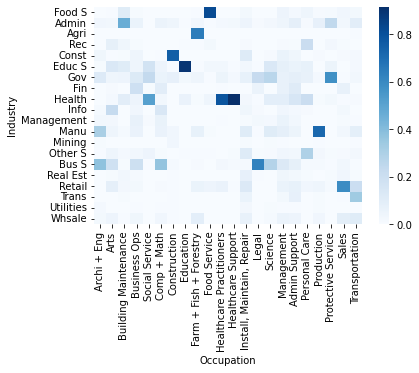

In [5]:
sns.heatmap(pivot_df, cmap="Blues")
plt.xlabel('Occupation')
plt.ylabel('Industry')